# Dog Breed Image Classifier

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [4]:
# import my ass
labels = pd.read_csv("drive/MyDrive/Work/DL/Test/dog-breed-identification/labels.csv")

## Highest 5 breed counts in our data

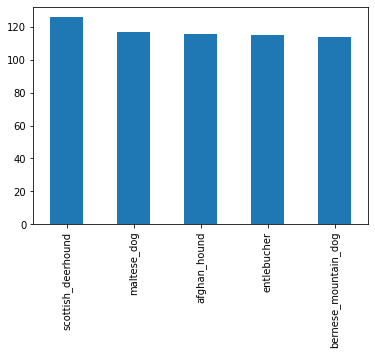

In [5]:
labels.breed.value_counts()[:5].plot(kind="bar");

## Getting Data Ready

In [6]:
#id setup
file_names = ["drive/MyDrive/Work/DL/Test/dog-breed-identification/train/"+id+".jpg" for id in labels.id]
len(file_names)

10222

In [7]:
#breed setup
breeds = labels.breed.to_numpy()
u_breed = np.unique(breeds)
b_labels = [breed == u_breed for breed in breeds]


In [8]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(file_names,b_labels,test_size=0.2)
len(x_train) ,len(x_val),len(y_train),len(y_val)

(8177, 2045, 8177, 2045)

In [9]:
x_train[0],y_train[0]

('drive/MyDrive/Work/DL/Test/dog-breed-identification/train/164a194e9bf8819523235879eb0c2698.jpg',
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,

In [10]:
#Turn our ids(labels) and image into tensors image to batchfiles
IMG_SIZE = 224
def process_image(image_path,img_size=IMG_SIZE):
  """
  process the image by taking its path and returnning it as a tensor shape(Still
  needs to be turned into batches
  """
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size=[img_size,img_size])
  return image

In [11]:
def get_image_label(image_path,label):
  """
  takes an image path and its label and return a tuble of processed image(as 
  tensor) and its label (as numpy array)
  """
  image = process_image(image_path)
  return image,label

In [12]:
BATCH = 32
def create_data_patches(x,y=None,batch_size=BATCH,val_data=False,
                        test_data=False):
  """
  Creates batches of ata out of x and y (if given)
  shuffles the data if it is trainning data and doesnt if it is validation data
  if the input is only x(test data) it handles it without labels(batchifys them)
  """
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))  
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  elif val_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))  
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  
  else:
    print("Creating train data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data = data.shuffle(buffer_size=len(x))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

In [13]:
train_data = create_data_patches(x_train,y_train)
val_data = create_data_patches(x_val,y_val,val_data=True)

Creating train data batches...
Creating valid data batches...


In [14]:
train_images,train_labels = next(train_data.as_numpy_iterator())

In [15]:
def show_10_images(images,labels):
  """
  takes datapatch of images and labels and visualizes them
  """
  plt.figure(figsize=(20,20))
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(u_breed[labels[i].argmax()])
    plt.axis("off")

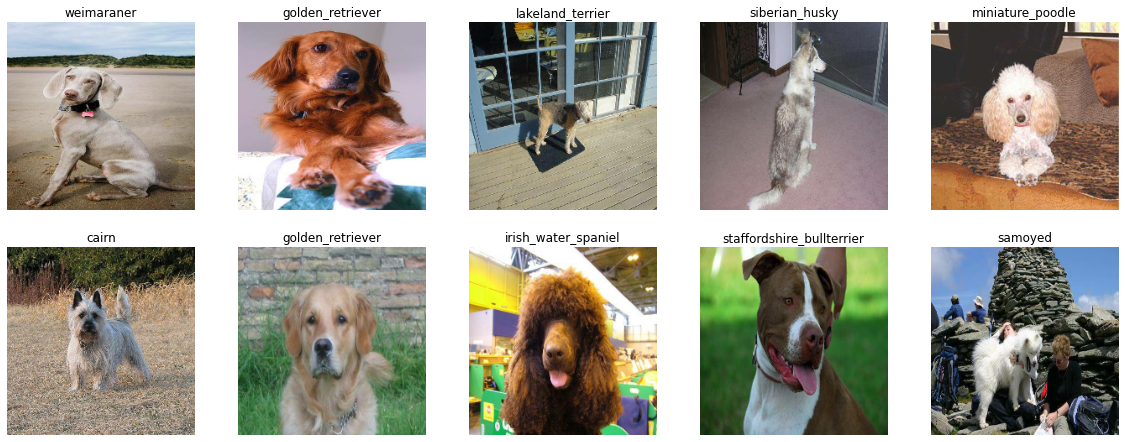

In [16]:
show_10_images(train_images,train_labels)

## Creating our Model

In [17]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(u_breed)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"

In [18]:
def create_model(input_layer=INPUT_SHAPE,output_layer=OUTPUT_SHAPE,
                model_url=MODEL_URL):
  """
  takes the input layer and output layer and the model url and builds and 
  compiles the model then return it
  """
  model = tf.keras.Sequential([hub.KerasLayer(model_url),
                               tf.keras.layers.Dense(units=output_layer,activation="softmax")])
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
  model.build(input_layer)
  return model

In [19]:
# model = create_model()
# model.summary()

In [20]:
#Callbacks to evaluate the model preformance and stops it before overfitting
%load_ext tensorboard

## Getting our model Ready for Training

In [21]:
import os
import datetime as dt
def create_tensorboard_callback():
  log_dir = os.path.join("/content/drive/MyDrive/Work/DL/Test/logs",dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir)

In [22]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                       patience=3)

In [23]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(train_data,validation_data=val_data,epochs=100,validation_freq=1,
            callbacks=[early_stop_callback,tensorboard])
  return model

In [24]:
#model = train_model()
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [25]:
# model.save("/content/drive/MyDrive/Work/DL/models/dogs.h5")
# model.save("/content/drive/MyDrive/Work/DL/models/dogs.tf")
model = tf.keras.models.load_model("/content/drive/MyDrive/Work/DL/models/dogs.h5",custom_objects={"KerasLayer":hub.KerasLayer})

## Predicting on the Validation Dataset

In [26]:
pred_data = model.predict(val_data)
pred_data

64/64 [==============================] - 724s 11s/step


In [27]:
#lets unbatch a dataset so we can see the picture and know the label and then 
#compare it to our prediction
def unbatchify(data):
  unbatched_images = []
  unbatched_labels = []
  for image,label in data.unbatch().as_numpy_iterator():
    unbatched_images.append(image)
    unbatched_labels.append(u_breed[label.argmax()])
  return unbatched_images,unbatched_labels


## Visualizing Predictions

In [28]:
def plot_predictions(pred_data,images,labels,n=0):
  """
  view the prediction and the image and the true breed
  """
  pred_label,true_label,image,pred_values = u_breed[pred_data[n].argmax()], labels[n], images[n],pred_data[n]
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  plt.title(f"Prediction: {pred_label.title()} | Percentage: {pred_values.max()*100:2.0f}% | Reality: {true_label.title()}",color=color)

In [29]:
images,labels = unbatchify(val_data)

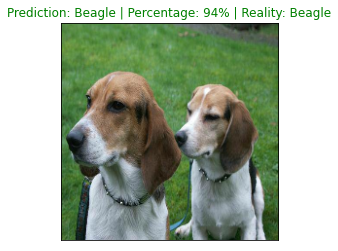

In [30]:
plot_predictions(pred_data,images,labels,789)